# Simulating noise-embedded oscillatory signals with neurodsp.sim
In this notebook, we simulate brown noise, a stationary oscillator, and the two together using the simulation library, `sim`, in `neurodsp`.

In [54]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

from neurodsp import spectral, sim

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate brown noise
Often, we want to simulate noise that is comparable to what we see in neural recordings. Brown noise is a good proxy for that because, like neural signals, power decreases roughly linearly with frequency.

-2


Text(0,0.5,'Power')

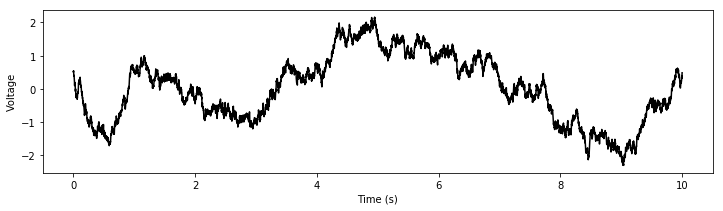

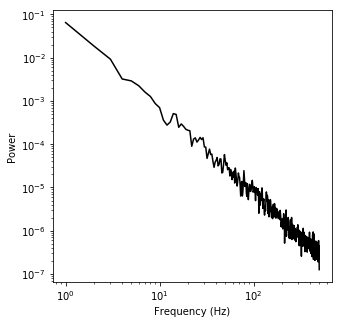

In [3]:
# Simulate brown noise
n_seconds = 10
fs = 1000
exponent = -2
t = np.arange(0, n_seconds, 1/fs)
br_noise = sim.sim_variable_powerlaw(n_seconds, fs, exponent)

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(t, br_noise, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
freqs, psd = spectral.compute_spectrum(br_noise, fs)
plt.figure(figsize=(5,5))
plt.loglog(freqs, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate filtered brown noise
However, brown noise has a lot of power in very slow frequnecies, whereas these slow frequencies are often not present or filtered out in neural signals. Therefore, we may desire our brown noise to be high-pass filtered.

Note this might not be ideal because it somewhat creates an oscillation at the cutoff frequency

In [18]:
# Simulate highpass-filtered brown noise with a 1Hz cutoff frequency, and a filter of length 3 seconds
f_hipass_brown = 1
filter_length = int(Fs * 3)
brown_filt = neurodsp.sim_filtered_brown_noise(N_seconds, Fs, (f_hipass_brown, None), filter_length)

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(t, brown_filt, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.psd(brown_filt, Fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

AttributeError: module 'neurodsp' has no attribute 'sim_filtered_brown_noise'

# Simulate an oscillator
In addition to noise, you may also want to simulate an oscillatory process. We can do that with neurodsp, with arbitrary rise-decay symmetry.

Text(0,0.5,'Power')

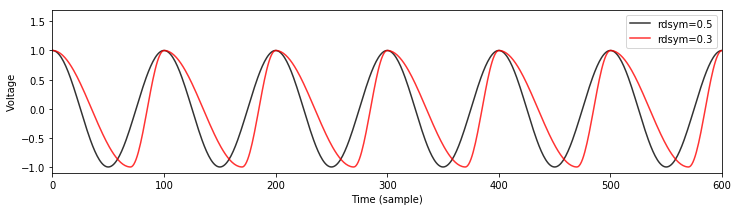

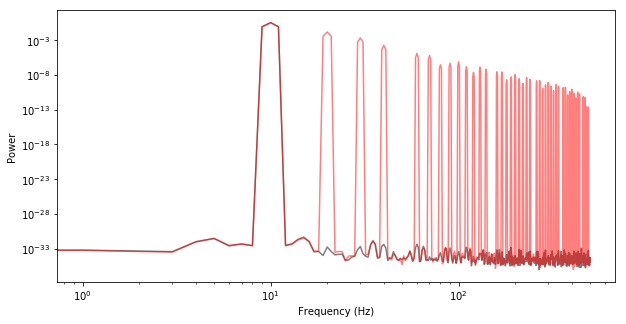

In [4]:
# Simulate symmetric oscillator
N_samples_cycle = 100
N_cycles = 100
oscA = neurodsp.sim_oscillator(N_samples_cycle, N_cycles, rdsym=.5)
oscB = neurodsp.sim_oscillator(N_samples_cycle, N_cycles, rdsym=.3)

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(oscA, 'k', label='rdsym='+str(.5), alpha=.8)
plt.plot(oscB, 'r', label='rdsym='+str(.3), alpha=.8)
plt.ylim((-1.1, 1.7))
plt.xlim((0,600))
plt.legend()
plt.xlabel('Time (sample)')
plt.ylabel('Voltage')

# Plot power spectrum
fA, psdA = spectral.psd(oscA, 1000)
fB, psdB = spectral.psd(oscB, 1000)
plt.figure(figsize=(10,5))
plt.loglog(fA, psdA, 'k', alpha=.5)
plt.loglog(fB, psdB, 'r', alpha=.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate a noisy oscillator
In order to simulate a signal that looks more like a brain signal, you may want to simulate both an oscillation and noise. We can also do this with neurodsp, with control over the power ratio between oscillation and noise

Text(0,0.5,'Power')

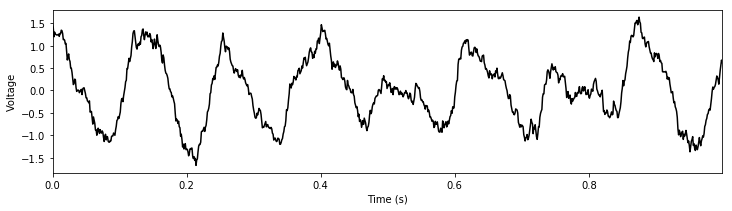

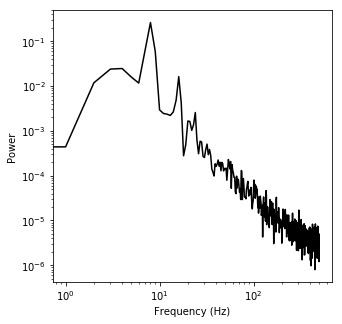

In [5]:
freq = 8
T = 5
Fs = 1000
rdsym = .3
f_hipass_brown = 2
SNR = 3
t = np.arange(0, T, 1/Fs)
signal = neurodsp.sim_noisy_oscillator(freq, T, Fs, rdsym=rdsym,
                                       f_hipass_brown=f_hipass_brown, SNR=SNR)

plt.figure(figsize=(12,3))
samps_plot = np.arange(1000)
plt.plot(t[samps_plot], signal[samps_plot], 'k')
plt.xlim((0,t[samps_plot[-1]]))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.psd(signal, Fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate a bursting oscillator
Sometimes we want to study oscillations that come and go, so it can be useful to simulate oscillations with this property. We can do this by controlling the probability that a burst will start or stop with each new cycle.

Text(0,0.5,'Voltage')

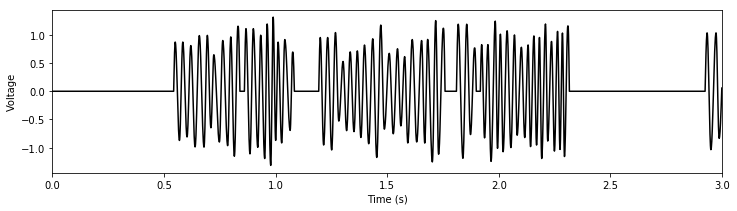

In [6]:
freq = 30
T = 3
Fs = 1000
prob_enter_burst = .1
prob_leave_burst = .1

osc = neurodsp.sim_bursty_oscillator(freq, T, Fs, rdsym=None,
                                     prob_enter_burst=prob_enter_burst,
                                     prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,T,1/Fs), osc, 'k')
plt.xlim((0,T))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can increase shorten burst duration by increasing the probability to leave bursts

Text(0,0.5,'Voltage')

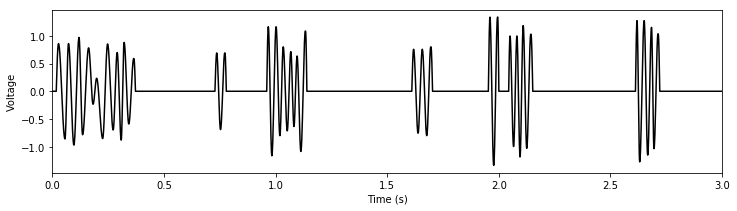

In [7]:
prob_leave_burst = .4

osc = neurodsp.sim_bursty_oscillator(freq, T, Fs, rdsym=None,
                                     prob_enter_burst=prob_enter_burst,
                                     prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,T,1/Fs), osc, 'k')
plt.xlim((0,T))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can increase the number of bursts by increasing the probability to enter a burst

Text(0,0.5,'Voltage')

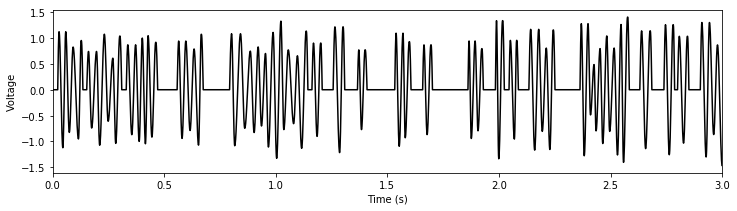

In [8]:
prob_enter_burst = .4

osc = neurodsp.sim_bursty_oscillator(freq, T, Fs, rdsym=None,
                                     prob_enter_burst=prob_enter_burst,
                                     prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,T,1/Fs), osc, 'k')
plt.xlim((0,T))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can also control the variance in amplitude, period, and rise-decay symmetry across cycles and bursts
This is done in the `cycle_features` argument, which is a dictionary that can take the following keys:
    * amp_mean - mean cycle amplitude
    * amp_std - standard deviation of cycle amplitude
    * amp_burst_std - std. of mean amplitude for each burst
    * period_mean - mean period (computed from `freq`)
    * period_std - standard deviation of period (samples)
    * period_burst_std - std. of mean period for each burst
    * rdsym_mean - mean rise-decay symmetry
    * rdsym_std - standard deviation of rdsym
    * rdsym_burst_std - std. of mean rdsym for each burst

See the source code for the defaults used.

For example, we can increase the variability in amplitude by increasing `amp_std` (default = .1)

Text(0,0.5,'Voltage')

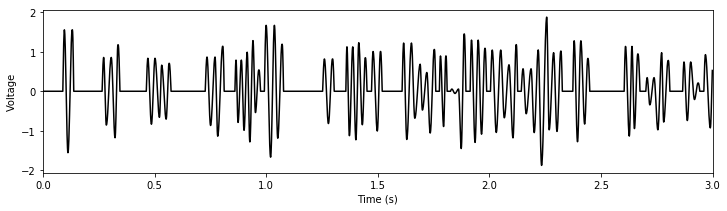

In [9]:
cycle_features = {'amp_std': .3}

osc = neurodsp.sim_bursty_oscillator(freq, T, Fs, rdsym=None,
                                     prob_enter_burst=prob_enter_burst,
                                     prob_leave_burst=prob_leave_burst,
                                     cycle_features=cycle_features)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,T,1/Fs), osc, 'k')
plt.xlim((0,T))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### As with the stationary oscillator, we can also simulate a bursting oscillator with brown noise

Text(0,0.5,'Power')

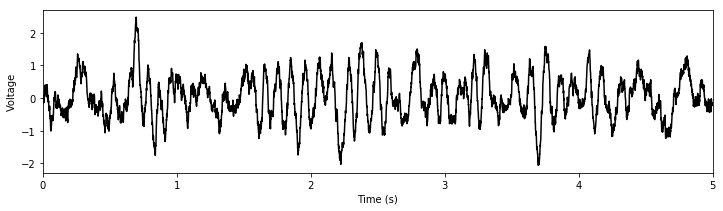

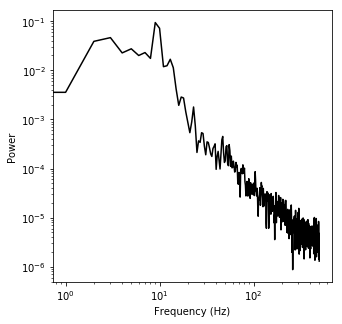

In [10]:
freq = 10
T = 5
osc = neurodsp.sim_noisy_bursty_oscillator(freq, T, Fs, SNR=2)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,T,1/Fs), osc, 'k')
plt.xlim((0,T))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.psd(osc, Fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')